In [88]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [89]:
from nn_resampler import nn_resampler
from phase_est_smc import phase_est_smc

In [90]:
num_particles = 100 # number of SMC particles (num of w points)
num_samples = 10000 # number of samples to draw from the particle distribution (to be binned)
num_bins = 100 # number of bins
n_iters = 100 # number of different omega*
t0 = 10 # starting time
max_iters = 50 # maximum number of iterations before breaking

In [91]:
net = nn_resampler(num_bins,num_bins)
net.load_state_dict(torch.load("model/nn_resampler.model"))
net.eval();

## NN Resampler

In [92]:
true_omegas = []
nn_preds = []
nn_data = []

for i in range(n_iters): 
    
    true_omega = np.random.uniform(low=-1, high =1) * np.pi
    
    true_omegas.append(true_omega)
    smc = phase_est_smc(true_omega, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
            
        nn_pred = net(torch.tensor(bins).float().unsqueeze(0)) ## convert to float tensor, then make dim [1, num_bins]
        smc.nn_bins_to_particles(nn_pred.detach().numpy(), edges)
        
        resample_counts += 1

        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break         
    
    nn_data.append(smc.data)
    nn_preds.append(smc.curr_omega_est)
    
    if np.abs(true_omega - smc.curr_omega_est) > 1:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}. Failed".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    else:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))

True omega: -0.007812, prediction by NN: 0.644548, num of resample calls: 10
True omega: 0.313978, prediction by NN: 1.588010, num of resample calls: 10. Failed
True omega: 2.269441, prediction by NN: -1.883799, num of resample calls: 9. Failed
True omega: 2.384617, prediction by NN: 2.281419, num of resample calls: 11
True omega: 2.206056, prediction by NN: -1.373404, num of resample calls: 10. Failed
True omega: -2.876719, prediction by NN: -1.448141, num of resample calls: 10. Failed
True omega: 0.809347, prediction by NN: 0.583875, num of resample calls: 10
True omega: -0.703962, prediction by NN: -1.314797, num of resample calls: 11
True omega: 2.794043, prediction by NN: -0.842224, num of resample calls: 9. Failed
True omega: -0.936191, prediction by NN: -1.484383, num of resample calls: 10
True omega: -3.060279, prediction by NN: -3.060380, num of resample calls: 7
True omega: -2.423547, prediction by NN: -1.811211, num of resample calls: 10
True omega: -3.068746, prediction by 

In [93]:
nn_mse = np.mean( (np.array(true_omegas) - np.array(nn_preds) ) ** 2 )
print(nn_mse)

5.408570287676906


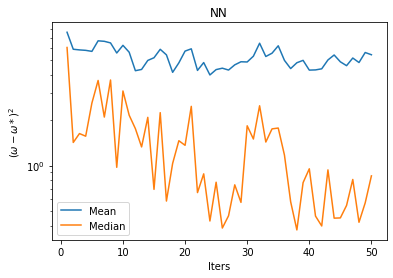

In [94]:
nn_data_squared = ( np.array(nn_data) - np.array(true_omegas).reshape(-1,1)) ** 2 
nn_data_mean = np.mean(nn_data_squared, axis=0)
nn_data_median = np.median(nn_data_squared, axis =0)

num_data_points = nn_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_median, label='Median')
plt.legend()
plt.title("NN")
plt.yscale('log')
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.show()

## Liu-West resampler

In [95]:
true_omegas = []
lw_preds = []
lw_data = []

for i in range(n_iters): 
    true_omega = np.random.uniform(low=-1, high=1) * np.pi
    
    true_omegas.append(true_omega)
    smc = phase_est_smc(true_omega, t0, max_iters)
    smc.init_particles(num_particles)
    
    resample_counts = 0
    
    while True:

        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        smc.liu_west_resample()
    
        resample_counts += 1 
        
        if smc.break_flag == True:
            break
        
#         if len(running_est) > 5:
#             last_5 = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shape of last_10 with every element being last_10[0]
#             # if all elements of last_10 are equal then they should all equal the first element
#             if np.allclose(last_5, np.full_like(last_5, last_5[0])):
#                 break

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate

    lw_data.append(smc.data)
    lw_preds.append(smc.curr_omega_est)
    
    if np.abs(true_omega - smc.curr_omega_est) > 1:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}. Failed".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    
    else:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    

True omega: 3.087583, prediction by NN: 3.516780, num of resample calls: 11
True omega: -1.367253, prediction by NN: -2.772652, num of resample calls: 11. Failed
True omega: -2.512918, prediction by NN: 2.170502, num of resample calls: 11. Failed
True omega: 2.430231, prediction by NN: -0.234708, num of resample calls: 11. Failed
True omega: -3.055301, prediction by NN: 2.724159, num of resample calls: 11. Failed
True omega: -0.671390, prediction by NN: 0.221836, num of resample calls: 11
True omega: 1.356123, prediction by NN: 0.626896, num of resample calls: 11
True omega: 2.740511, prediction by NN: -1.552198, num of resample calls: 11. Failed
True omega: 0.797891, prediction by NN: 1.346313, num of resample calls: 11
True omega: 1.654585, prediction by NN: 2.198337, num of resample calls: 11
True omega: 1.471510, prediction by NN: 2.356464, num of resample calls: 11
True omega: -0.147524, prediction by NN: -0.197066, num of resample calls: 11
True omega: 2.570833, prediction by NN:

In [96]:
lw_mse = np.mean( (np.array(true_omegas) - np.array(lw_preds)) ** 2 )
print(lw_mse)

6.6525989752913635


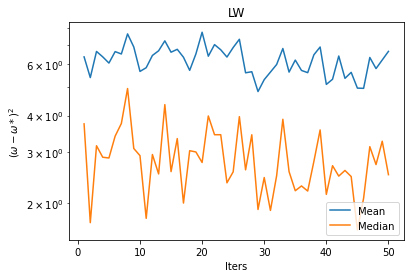

In [97]:
lw_data_squared = ( np.array(lw_data) - np.array(true_omegas).reshape(-1,1)) ** 2 
lw_data_mean = np.mean(lw_data_squared, axis=0)
lw_data_median = np.median(lw_data_squared, axis =0)

num_data_points = lw_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_median, label='Median')
plt.legend()
plt.title("LW")
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.yscale('log')
plt.show()